<a href="https://colab.research.google.com/github/Kathir00/object-classification/blob/main/cat_or_dog_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 — loss 0.388, acc 0.831, prec 0.825, rec 0.840, f1 0.832
Epoch 2 — loss 0.375, acc 0.824, prec 0.762, rec 0.943, f1 0.843
Epoch 3 — loss 0.291, acc 0.874, prec 0.962, rec 0.780, f1 0.861
Epoch 4 — loss 0.229, acc 0.900, prec 0.866, rec 0.948, f1 0.905
Epoch 5 — loss 0.251, acc 0.893, prec 0.982, rec 0.800, f1 0.882


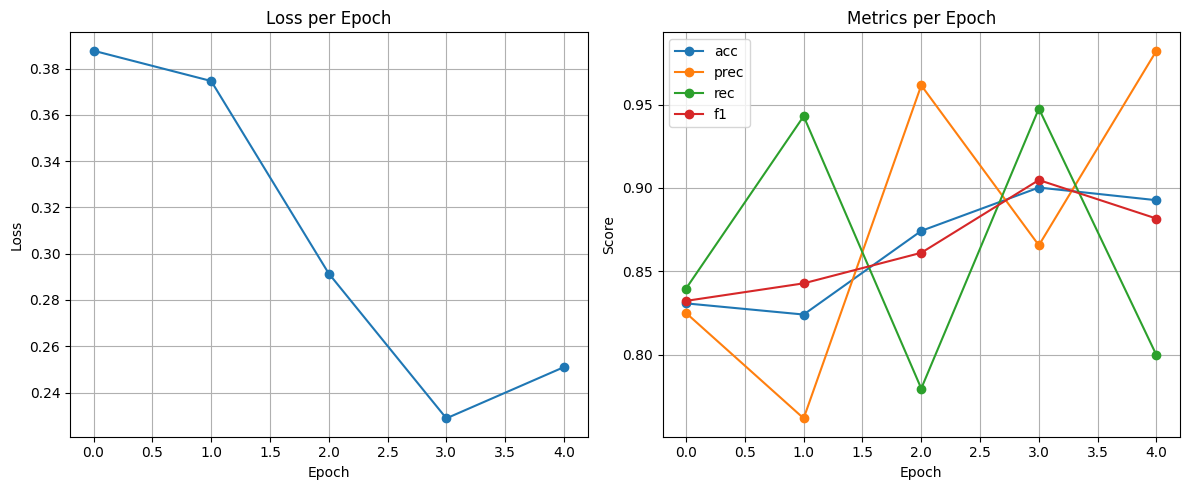

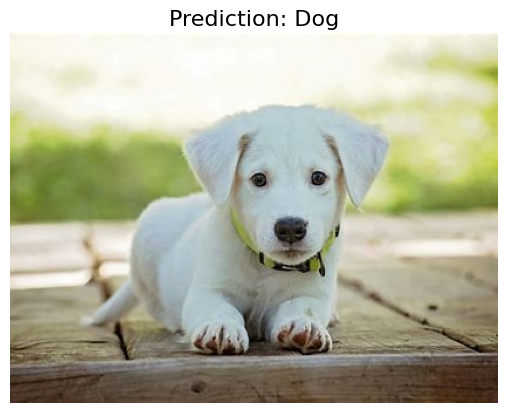

Prediction: Dog


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Subset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Device / transforms / data loader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load CIFAR10, filter cats (3) and dogs (5)
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
idx = [i for i, (_, l) in enumerate(cifar10) if l in [3, 5]]
subset = Subset(cifar10, idx)

class CatDogDataset(torch.utils.data.Dataset):
    def __init__(self, subset): self.subset = subset
    def __len__(self): return len(self.subset)
    def __getitem__(self, idx):
        img, lbl = self.subset[idx]
        return img, (0 if lbl == 3 else 1)

ds = CatDogDataset(subset)
loader = DataLoader(ds, batch_size=32, shuffle=True)

# Model setup
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# Training essentials
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Store metrics
history = {'loss': [], 'acc': [], 'prec': [], 'rec': [], 'f1': []}

# Training loop with metrics
for epoch in range(1, 6):
    model.train()
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            total_loss += criterion(logits, labels).item() * labels.size(0)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(ds)
    acc = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()
    prec = precision_score(all_labels, all_preds, average='binary', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='binary', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='binary', zero_division=0)

    for k, v in [('loss',avg_loss), ('acc',acc), ('prec',prec), ('rec',rec), ('f1',f1)]:
        history[k].append(v)

    print(f"Epoch {epoch} — loss {avg_loss:.3f}, acc {acc:.3f}, prec {prec:.3f}, rec {rec:.3f}, f1 {f1:.3f}")

# Plot metrics
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['loss'], '-o')
plt.title('Loss per Epoch'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True)
plt.subplot(1,2,2)
for m in ['acc','prec','rec','f1']:
    plt.plot(history[m], marker='o', label=m)
plt.title('Metrics per Epoch'); plt.xlabel('Epoch'); plt.ylabel('Score')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# Prediction + Visualization
def predict_and_show(image_path):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    t = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(t)
        pred = logits.argmax(dim=1).item()
    label = 'Cat' if pred == 0 else 'Dog'
    plt.imshow(img)
    plt.title(f"Prediction: {label}", fontsize=16)
    plt.axis('off')
    plt.show()
    return label


res = predict_and_show('/content/doggy.jfif')
print("Prediction:", res)




from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            loss = criterion(logits, labels)
            total_loss += loss.item() * labels.size(0)

            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    acc = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()
    prec = precision_score(all_labels, all_preds, average='binary', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='binary', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='binary', zero_division=0)

    return {
        'loss': avg_loss,
        'acc': acc,
        'prec': prec,
        'rec': rec,
        'f1': f1
    }



In [ ]:
cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
idx_test = [i for i, (_, l) in enumerate(cifar10_test) if l in [3, 5]]
subset_test = Subset(cifar10_test, idx_test)
test_ds = CatDogDataset(subset_test)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# Now evaluate on test set
test_metrics = evaluate_model(model, test_loader, criterion, device)
print("Test Metrics:", test_metrics)

Test Metrics: {'loss': 0.3677028231024742, 'acc': 0.843500018119812, 'prec': 0.9478487614080835, 'rec': 0.727, 'f1': 0.822863610639502}
